In [181]:
import pandas as pd
import numpy as np
import datetime
import spacy
import re
import torch
import pickle
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec

In [109]:
# Ознакомимся с нашим набором данных
df = pd.read_csv('../data/text.csv')

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). Whether you're interested in sentiment analysis, emotion classification, or text mining, this dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.

In [110]:
# проверим соотношение классов
df['label'].value_counts() / len(df['label']) * 100

label
1    33.844519
0    29.074948
3    13.751383
4    11.446970
2     8.290128
5     3.592053
Name: count, dtype: float64

In [112]:
# так как производительности моего компьютера не хватает для обработки такого количества данных, я возьму только 10% данных с таким-же соотношением классов
df_subset_text, _, df_subset_label, _ = train_test_split(df.drop(['label'], axis=1), df['label'], train_size=0.1, random_state=42, stratify=df[['label']])
df = df.drop(['Unnamed: 0'], axis=1)

In [113]:
# мой сабсет с которым я буду работать
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [114]:
# проверим наличие верхнего регистра в тексте
mask_uppercase = df['text'].str.isupper()
df[mask_uppercase]

,text,label


In [7]:
# проверим наличие упоминаний пользователей. Сначала создам функцию
def check_user_mentions(text):
    pattern = r'@(\w+)'
    mentions = re.findall(pattern, text)
    return mentions

In [115]:
mentions = []
for twit in df['text']:
    if len(check_user_mentions(twit)) > 0:
        mentions.append(twit)
        
print(mentions)

[]


In [116]:
# Исправляю сокращённые формы, которые могут быть неправильно обработаны токенизатором и лемматизатором spaCy
def expand_contractions(text):
    contractions = {
        "im": "i am",
        "i m": "i am",
        "i ll": "i will",
        "i ve": "i have",
        "ive": "i have",
        "i d": "i would",
        "id": "i would",
        "youre": "you are",
        "you re": "you are",
        "youll": "you will",
        "you ll": "you will",
        "youve": "you have",
        "you ve": "you have",
        "youd": "you would",
        "you d": "you would",
        "hes": "he is",
        "he s": "he is",
        "he ll": "he will",
        "he d": "he would",
        "hed": "he would",
        "shes": "she is",
        "she s": "she is",
        "she ll": "she will",
        "shell": "she will",
        "she d": "she would",
        "shed": "she would",
        "it s": "it is",
        "it d": "it would",
        "itd": "it would",
        "we re": "we are",
        "we ll": "we will",
        "we ve": "we have",
        "weve": "we have",
        "we d": "we would",
        "wed": "we would",
        "they re": "they are",
        "theyre": "they are",
        "theyll": "they will",
        "they ll": "they will",
        "they ve": "they have",
        "theyve": "they have",
        "theyd": "they would",
        "they d": "they would",
        "don t": "do not",
        "dont": 'do not',
        "doesn t": "does not",
        "didn t": "did not",
        "didnt": "did not",
        "haven t": "have not",
        "hasn t": "has not",
        "hadn t t": "had not",
        "wouldn t": "would not",
        "won t": "will not",
        "wont": "will not",
        "can t": "can not",
        "cant": "can not",
        "couldn t t": "could not",
        "couldnt": "could not",
        "shouldn t": "should not",
        "shouldnt": "should not",
        "isn t": "is not",
        "isnt": "is not",
        "weren t": "were not",
        "werent": "were not",
        "wasn t": "was not",
        "wasnt": "was not",
        "aren t": "are not",
        "arent": "are not",
        "woulndnt t ve": "would not have",
        "woulndnttve": "would not have",
        "shoulndnt t ve": "should not have",
        "shoulndnttve": "should not have"
    }

    for contraction, expansion in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', expansion, text)

    return text

In [117]:
# Применяю функцию. Сохраняю результат в тот же датасет, заменив оригинальные данные обработанными
df['text'] = df['text'].apply(expand_contractions)

In [118]:
# для удаления стоп-слов и токенизации буду использовать пакет SpaCy
nlp = spacy.load("en_core_web_sm")

In [119]:
# определяю функцию, которая будет возвращать леммы без стоп-слов
def process_text_with_spacy(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop]

In [120]:
# вызываю написанную выше функцию и получаю список списков с обработанным текстом
tokenized_text = []

for text in df['text']:
    token = process_text_with_spacy(text)
    tokenized_text.append(token)

In [182]:
# Сохранение списка в файл
with open('tokenized_text.pkl', 'wb') as f:
    pickle.dump(tokenized_text, f)

# Загрузка списка из файла
with open('tokenized_text.pkl', 'rb') as f:
    tokenized_text = pickle.load(f)

In [122]:
# буду использовать word2vec для эмбеддинга
w2v_model = Word2Vec(tokenized_text, vector_size=100, workers=4)

In [123]:
# Получу векторные представления слов для каждого документа и усредняю веркторы в документе. Сохраняю индексы документов, для которых не нашлось векторных представлений слов
empty_doc_indexes = []
document_vectors = []
for i, document in enumerate(tokenized_text):
    doc_vectors = [w2v_model.wv[word] for word in document if word in w2v_model.wv]

    if doc_vectors:
        avg_doc_vector = np.mean(doc_vectors, axis=0)
        document_vectors.append(avg_doc_vector)
    else:
        empty_doc_indexes.append(i)

In [131]:
# Удалю метки для документов, слова в которых не получили векторное представление
labels_list = df['label'].values.tolist()
for index in sorted(empty_doc_indexes, reverse=True):
    labels_list.pop(index)

In [132]:
# Создаю тензоры для данных и их меток
document_vectors_np = np.array(document_vectors)
document_vectors_tensor = torch.tensor(document_vectors_np)
labels_tensor = torch.tensor(labels_list)

In [337]:
# Делю данные на тренировочные и тестовые/валидационные
train_data, test_val_data, train_labels, test_val_labels = train_test_split(document_vectors_tensor, labels_tensor, train_size=0.7, random_state=123, stratify=labels_tensor)

In [338]:
# Разделяю тестовые/валидационные на тестовые и валидационные
test_data, val_data, test_lables, val_lables = train_test_split(test_val_data, test_val_labels, train_size=0.5, random_state=123, stratify=test_val_labels)

In [339]:
# Стандартизую данные
mean = torch.mean(train_data, dim=0)
std = torch.std(train_data, dim=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
val_data = (val_data - mean) / std

In [340]:
# Создаю измерение батчей
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_lables)
test_dataset = TensorDataset(test_data, test_lables)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [341]:
import torch.nn.functional as F

class SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)  # Здесь p - вероятность обнуления

    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)

        return out

In [342]:
def training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader=None):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loss_train = 0.0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        avg_loss_train = loss_train / len(train_loader)
        train_losses.append(avg_loss_train)

        if val_loader is not None:
            val_loss = 0.0
            with torch.no_grad():
                for val_data, val_labels in val_loader:
                    val_outputs = model(val_data)
                    val_loss += criterion(val_outputs, val_labels).item()
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

        # Вывод средней потери на каждой эпохе
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print('{} Epoch {}, Training loss: {:.4f}'.format(
                datetime.datetime.now(), epoch + 1, avg_loss_train))
            if val_loader is not None:
                print('{} Epoch {}, Validation loss: {:.4f}'.format(
                    datetime.datetime.now(), epoch + 1, avg_val_loss))

    return train_losses, val_losses

In [343]:
def plot_losses(train_losses, val_losses=None):
    plt.plot(train_losses, label='Training loss')
    if val_losses:
        plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses')
    plt.show()

In [389]:
n_epochs = 15
batch_size = 64
learning_rate = 0.055

model = SeqModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [390]:
train_losses, val_losses = training_loop(n_epochs, optimizer, model, criterion, train_loader, val_loader)

2024-03-21 18:58:22.205393 Epoch 1, Training loss: 0.7931
2024-03-21 18:58:22.205518 Epoch 1, Validation loss: 0.6905
2024-03-21 18:58:40.669440 Epoch 10, Training loss: 0.5171
2024-03-21 18:58:40.669590 Epoch 10, Validation loss: 0.5586


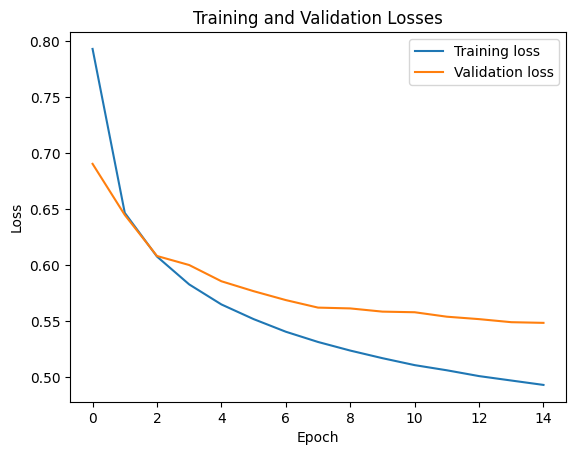

In [391]:
plot_losses(train_losses, val_losses)

In [392]:
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for val_data, val_labels in val_loader:
        val_outputs = model(val_data)
        val_loss += criterion(val_outputs, val_labels).item()
        _, predicted = torch.max(val_outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

print('Validation loss: {:.4f}'.format(val_loss / len(val_loader)))
print('Validation accuracy: {:.2f}%'.format(100 * correct / total))

Validation loss: 0.5486
Validation accuracy: 78.40%


In [393]:
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for test_data, test_labels in test_loader:
        test_outputs = model(test_data)
        test_loss += criterion(test_outputs, test_labels).item()
        _, predicted = torch.max(test_outputs, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print('Test loss: {:.4f}'.format(test_loss / len(test_loader)))
print('Test accuracy: {:.2f}%'.format(100 * correct / total))

Test loss: 0.5449
Test accuracy: 78.70%
